In [1]:
import regex as re
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from collections import defaultdict , Counter
import os , hashlib , subprocess
from datetime import datetime, timedelta
from typing import Dict, Optional
from urllib.parse import urlparse, parse_qs
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.sparse import hstack
from sklearn.metrics import silhouette_score
from scipy.sparse import csr_matrix
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

LOG_FILE = r"C:\Users\dell\Desktop\BreachLens\simulated_access_log.log"

In [2]:
TIME_THRESHOLD_MINUTES = 15  # Max gap between requests to count in same session

In [3]:
log_pattern=re.compile(
        r'(?P<ip>\S+) - - \[(?P<time>[^\]]+)\] '
        r'"(?P<method>\S+) (?P<url>\S+) (?P<protocol>[^"]+)" '
        r'(?P<status>\d{3}) (?P<size>\d+|-) '
        r'"(?P<referrer>[^"]*)" "(?P<user_agent>[^"]*)"'
    )

In [4]:
# Parse timestamp into datetime object
def parse_time(timestr):
    return datetime.strptime(timestr, "%d/%b/%Y:%H:%M:%S %z")

In [5]:
def parse_log_file(log_file_path):
    session_records = []
    sessions = {}

    with open(log_file_path, "r") as f:
        for line in f:
            match = log_pattern.match(line)
            if match:
                data = match.groupdict()
                timestamp = parse_time(data['time'])
                key = (data['ip'], data['user_agent'])

                if key not in sessions:
                    sessions[key] = []
                sessions[key].append((timestamp, line.strip()))

                session_records.append({
                    "ip": data['ip'],
                    "user_agent": data['user_agent'],
                    "timestamp": timestamp,
                    "method": data['method'],
                    "url": data['url'],
                    "status": int(data['status']),
                    "size": int(data['size']),
                    "referrer": data['referrer'],
                    "protocol": data['protocol']
                })

    session_df = pd.DataFrame(session_records)
    session_df['ip_freq'] = session_df['ip'].map(session_df['ip'].value_counts())

    return session_df, sessions

In [6]:
session_df, sessions = parse_log_file(LOG_FILE)

In [7]:
sessions

{('36.115.243.206',
  'Mozilla/5.0 (X11; Linux x86_64)'): [(datetime.datetime(2025, 1, 27, 23, 39, 35, tzinfo=datetime.timezone(datetime.timedelta(seconds=19800))),
   '36.115.243.206 - - [27/Jan/2025:23:39:35 +0530] "POST main/list/tags HTTP/1.1" 301 3284 "http://www.randall-day.com/index/" "Mozilla/5.0 (X11; Linux x86_64)"')],
 ('124.50.101.62',
  'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7)'): [(datetime.datetime(2025, 3, 23, 9, 34, 19, tzinfo=datetime.timezone(datetime.timedelta(seconds=19800))),
   '124.50.101.62 - - [23/Mar/2025:09:34:19 +0530] "HEAD explore HTTP/1.1" 301 3880 "http://walsh.info/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7)"')],
 ('60.153.169.13',
  'curl/7.68.0'): [(datetime.datetime(2025, 6, 21, 19, 41, 31, tzinfo=datetime.timezone(datetime.timedelta(seconds=19800))),
   '60.153.169.13 - - [21/Jun/2025:19:41:31 +0530] "POST main HTTP/1.1" 500 1582 "https://anderson-cuevas.org/home/" "curl/7.68.0"')],
 ('126.237.5.191',
  'Mozilla/5.0 (Windows NT 10.0; 

In [8]:
session_df

,ip,user_agent,timestamp,method,url,status,size,referrer,protocol,ip_freq
0,36.115.243.206,Mozilla/5.0 (X11; Linux x86_64),2025-01-27 23:39:35+05:30,POST,main/list/tags,301,3284,http://www.randall-day.com/index/,HTTP/1.1,1
1,124.50.101.62,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7),2025-03-23 09:34:19+05:30,HEAD,explore,301,3880,http://walsh.info/,HTTP/1.1,1
2,60.153.169.13,curl/7.68.0,2025-06-21 19:41:31+05:30,POST,main,500,1582,https://anderson-cuevas.org/home/,HTTP/1.1,1
3,126.237.5.191,Mozilla/5.0 (Windows NT 10.0; Win64; x64),2025-01-12 06:37:39+05:30,POST,list,302,4137,http://www.gomez.info/blog/explore/main/post.htm,HTTP/1.1,1
4,64.251.98.165,Mozilla/5.0 (Windows NT 10.0; Win64; x64),2025-05-21 04:34:29+05:30,HEAD,categories/tags/tag,404,2300,https://francis.info/post.php,HTTP/1.1,1
...,...,...,...,...,...,...,...,...,...,...
49995,87.191.50.159,Mozilla/5.0 (X11; Linux x86_64),2025-03-20 19:26:17+05:30,HEAD,blog/tag/tags,200,471,http://patterson.net/register/,HTTP/1.1,1
49996,63.176.144.9,curl/7.68.0,2025-03-25 10:10:39+05:30,GET,explore/tag,500,4126,https://www.rogers-johnson.com/category.jsp,HTTP/1.1,1
49997,62.197.255.115,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7),2025-01-17 06:51:39+05:30,GET,main/category/posts,301,4572,http://www.thompson.com/main/,HTTP/1.1,1
49998,16.165.92.181,Mozilla/5.0 (X11; Linux x86_64),2025-01-03 05:47:25+05:30,HEAD,tag/list,301,175,https://gordon-thompson.com/main.php,HTTP/1.1,1


In [9]:
"""Parse a log line in Apache/Nginx Combined Log Format."""

def parse_combined_log(line: str) -> Optional[Dict]:
    log_pattern = (
        r'(?P<ip>\S+) - - \[(?P<time>[^\]]+)\] '
        r'"(?P<method>\S+) (?P<url>\S+) (?P<protocol>[^"]+)" '
        r'(?P<status>\d{3}) (?P<size>\d+|-) '
        r'"(?P<referrer>[^"]*)" "(?P<user_agent>[^"]*)"'
    )
    match = re.match(log_pattern, line)
    return match.groupdict() if match else None

In [10]:
"""Detect path traversal attempts (e.g., ../../../etc/passwd)."""

def detect_directory_traversal(url: str) -> bool:

    patterns = [
        r'\.\./',       # ../ 
        r'%2e%2e%2f',   # URL-encoded ../
        r'\.\.%5c',     # ..\ (Windows)
        r'etc/passwd'    # Target file
    ]
    return any(re.search(p, url, re.I) for p in patterns)

In [11]:
def detect_sqli(url: str) -> bool:

    """Detect SQLi patterns like UNION SELECT, ' OR 1=1 --."""
    patterns = [
        r'union\s+select',
        r'\'\s+or\s+1=1',
        r'select.*from',
        r';\s*(--|#)',
        r'exec\(',
        r'waitfor\s+delay'
    ]
    return any(re.search(p, url, re.I) for p in patterns)

In [12]:
def detect_xss(url: str) -> bool:

    """Detect XSS attempts like <script>, alert()."""
    patterns = [
        r'<script>',        # <script> tag
        r'alert\(',          # alert()
        r'onerror=',         # event handler
        r'javascript:',      # JS protocol
        r'%3Cscript%3E'      # URL-encoded <script>
    ]
    return any(re.search(p, url, re.I) for p in patterns)

In [13]:
login_attempts = defaultdict(list)  # Store timestamps instead

def detect_brute_force(log_entry: Dict, time_window_min: int = 15, threshold: int = 5) -> bool:
    if log_entry['url'] == '/login' and log_entry['status'] == '401':
        ip = log_entry['ip']
        now = datetime.now()
        login_attempts[ip].append(now)
        # Remove attempts older than time_window_min
        login_attempts[ip] = [t for t in login_attempts[ip] if now - t < timedelta(minutes=time_window_min)]
        return len(login_attempts[ip]) >= threshold
    return False

In [14]:
"""Flag curl, bots, or empty User-Agents."""
def detect_user_agent_spoofing(user_agent: str) -> bool:
    suspicious_agents = [
        r'curl',          # curl
        r'wget',          # wget
        r'python-requests', # Python scripts
        r'^$'             # Empty UA
    ]
    return any(re.search(p, user_agent, re.I) for p in suspicious_agents)

In [15]:
request_counts = defaultdict(int)

def detect_dos(log_entry: Dict, threshold: int = 100) -> bool:
    """Detect high request volume from a single IP."""
    ip = log_entry['ip']
    request_counts[ip] += 1
    return request_counts[ip] >= threshold

In [16]:
def detect_suspicious_download(url: str) -> bool:
    
    """Detect downloads of sensitive files."""
    patterns = [
        r'\.sql$',        # .sql files
        r'\.env$',        # .env files
        r'\.bak$',        # Backups
        r'\/wp-config\.php'  # WordPress config
    ]
    return any(re.search(p, url, re.I) for p in patterns)

In [17]:
def detect_file_upload_exec(url: str) -> bool:
    """Detect uploaded executable files."""
    patterns = [
        r'\/uploads\/.*\.php$',  # PHP in uploads
        r'\.jsp$',               # JSP files
        r'cmd=whoami'            # RCE attempts
    ]
    return any(re.search(p, url, re.I) for p in patterns)

In [18]:
# Example output structure:
# final_sessions = {
#     (1, ['192.168.1.1'], 'curl/7.68.0', ['sqli', 'user_agent_spoofing']): [
#         ['2023-01-01', '00:00:01', 'log line 1...'],
#         ['2023-01-01', '00:00:02', 'log line 2...']
#     ],
#     ...
# }

def sessionIdentification(sessions):
    
    final_sessions = {}
    session_counter = 1
    
    for key, logs in sessions.items():
        logs.sort()
        session = [logs[0][1]]
        session_ips = {key[0]}  # Track IPs in session
        user_agent = key[1]
        anomalies = set()  # Track all anomalies in session
        
        # Parse first log entry for anomalies
        first_entry = parse_combined_log(logs[0][1])
        if first_entry:
            if detect_directory_traversal(first_entry['url']):
                anomalies.add('directory_traversal')
            if detect_sqli(first_entry['url']):
                anomalies.add('sqli')
            if detect_xss(first_entry['url']):
                anomalies.add('xss')
            if detect_brute_force(first_entry):
                anomalies.add('brute_force')
            if detect_dos(first_entry):
                anomalies.add('dos')
            if detect_user_agent_spoofing(first_entry['user_agent']):
                anomalies.add('user_agent_spoofing')
            if detect_suspicious_download(first_entry['url']):
                anomalies.add('suspicious_download')
            if detect_file_upload_exec(first_entry['url']):
                anomalies.add('file_upload_exec')
    
        for i in range(1, len(logs)):
            time_diff = (logs[i][0] - logs[i - 1][0]).total_seconds() / 60.0
            if time_diff <= TIME_THRESHOLD_MINUTES:
                session.append(logs[i][1])
                # Check for new IPs and anomalies in this log entry
                current_entry = parse_combined_log(logs[i][1])
                if current_entry:
                    if current_entry['ip'] not in session_ips:
                        session_ips.add(current_entry['ip'])
                    # Detect anomalies
                    if detect_directory_traversal(current_entry['url']):
                        anomalies.add('directory_traversal')
                    if detect_sqli(current_entry['url']):
                        anomalies.add('sqli')
                    if detect_xss(current_entry['url']):
                        anomalies.add('xss')
                    if detect_brute_force(current_entry):
                        anomalies.add('brute_force')
                    if detect_dos(current_entry):
                        anomalies.add('dos')
                    if detect_user_agent_spoofing(current_entry['user_agent']):
                        anomalies.add('user_agent_spoofing')
                    if detect_suspicious_download(current_entry['url']):
                        anomalies.add('suspicious_download')
                    if detect_file_upload_exec(current_entry['url']):
                        anomalies.add('file_upload_exec')
            else:
                if anomalies:
                    session_data = []
                    for log in session:
                        match = log_pattern.match(log)
                        if match:
                            data = match.groupdict()
                            dt = parse_time(data['time'])
                            session_data.append([
                                dt.strftime('%Y-%m-%d'),
                                dt.strftime('%H:%M:%S'),
                                log
                            ])
                    session_data.sort(key=lambda x: (x[0], x[1]))  # Sort by date then time
                    
                    # Create dictionary key
                    dict_key = (
                        session_counter,
                        tuple(list(session_ips)),  # Convert IP list to tuple
                        user_agent,
                        tuple(list(anomalies))     # Convert anomalies to tuple
                    )
                    final_sessions[dict_key] = session_data
                    session_counter += 1
                    
                # Reset for new session
                session = [logs[i][1]]
                session_ips = {key[0]}
                user_agent = key[1]
                anomalies = set()
                login_attempts.clear() 
                request_counts.clear()
    
        # Add the last session if it has anomalies
        if anomalies:
            session_data = []
            for log in session:
                match = log_pattern.match(log)
                if match:
                    data = match.groupdict()
                    dt = parse_time(data['time'])
                    session_data.append([
                        dt.strftime('%Y-%m-%d'),
                        dt.strftime('%H:%M:%S'),
                        log
                    ])
            session_data.sort(key=lambda x: (x[0], x[1]))
            
            dict_key = (
                session_counter,
                tuple(list(session_ips)),  # Convert IP list to tuple
                user_agent,
                tuple(list(anomalies))     # Convert anomalies to tuple
            )
    
            final_sessions[dict_key] = session_data
            session_counter += 1
    return final_sessions

final_sessions = sessionIdentification(sessions)


In [19]:
final_sessions

{(1,
  ('60.153.169.13',),
  'curl/7.68.0',
  ('user_agent_spoofing',)): [['2025-06-21',
   '19:41:31',
   '60.153.169.13 - - [21/Jun/2025:19:41:31 +0530] "POST main HTTP/1.1" 500 1582 "https://anderson-cuevas.org/home/" "curl/7.68.0"']],
 (2,
  ('166.94.85.205',),
  'Wget/1.20.3 (linux-gnu)',
  ('user_agent_spoofing',)): [['2025-05-12',
   '20:27:29',
   '166.94.85.205 - - [12/May/2025:20:27:29 +0530] "POST tags HTTP/1.1" 200 4554 "http://smith-powers.org/" "Wget/1.20.3 (linux-gnu)"']],
 (3,
  ('187.239.108.84',),
  'Wget/1.20.3 (linux-gnu)',
  ('user_agent_spoofing',)): [['2025-06-19',
   '04:01:45',
   '187.239.108.84 - - [19/Jun/2025:04:01:45 +0530] "POST blog/tag HTTP/1.1" 301 522 "https://www.ross.biz/tags/wp-content/register.htm" "Wget/1.20.3 (linux-gnu)"']],
 (4,
  ('171.196.228.103',),
  'Wget/1.20.3 (linux-gnu)',
  ('user_agent_spoofing',)): [['2025-02-17',
   '21:13:21',
   '171.196.228.103 - - [17/Feb/2025:21:13:21 +0530] "GET categories/category/posts HTTP/1.1" 200 1870 "h

In [20]:
# Define your anomaly types globally or pass them to the function
ANOMALY_TYPES = [
    'directory_traversal', 'sqli', 'xss',
    'brute_force', 'dos', 'user_agent_spoofing',
    'suspicious_download', 'file_upload_exec'
]

def extract_log_details(log_line, log_pattern, parse_time_func):
    """
    Extract structured data from a log line.
    Returns a dictionary or None if parsing fails.
    """
    match = log_pattern.match(log_line)
    if not match:
        return None
    data = match.groupdict()
    timestamp = parse_time_func(data['time'])
    return {
        "ip": data['ip'],
        "user_agent": data['user_agent'],
        "timestamp": timestamp,
        "method": data['method'],
        "url": data['url'],
        "status": int(data['status']),
        "size": int(data['size']),
        "referrer": data['referrer'],
        "protocol": data['protocol'],
    }

def build_final_dataframe(final_sessions, log_pattern, parse_time_func, anomaly_types=ANOMALY_TYPES):
    """
    Convert final_sessions into a pandas DataFrame with structured columns and anomaly flags.
    """
    rows = []

    for key, session_logs in final_sessions.items():
        session_id, ip_tuple, user_agent, anomalies_tuple = key

        date_start, time_start = session_logs[0][0], session_logs[0][1]
        date_end, time_end = session_logs[-1][0], session_logs[-1][1]
        log_count = len(session_logs)

        # Parse the first log line
        first_log_line = session_logs[0][2]
        log_details = extract_log_details(first_log_line, log_pattern, parse_time_func)
        if not log_details:
            continue

        row = {
            'session_id': session_id,
            'log_count': log_count,
            **log_details  # unpack the extracted log fields
        }

        for anomaly in anomaly_types:
            row[anomaly] = int(anomaly in anomalies_tuple)

        rows.append(row)

    df = pd.DataFrame(rows)
    df['ip_freq'] = df['ip'].map(df['ip'].value_counts())
    return df


In [21]:
final_df = build_final_dataframe(final_sessions, log_pattern, parse_time)

In [22]:
final_df

,session_id,log_count,ip,user_agent,timestamp,method,url,status,size,referrer,protocol,directory_traversal,sqli,xss,brute_force,dos,user_agent_spoofing,suspicious_download,file_upload_exec,ip_freq
0,1,1,60.153.169.13,curl/7.68.0,2025-06-21 19:41:31+05:30,POST,main,500,1582,https://anderson-cuevas.org/home/,HTTP/1.1,0,0,0,0,0,1,0,0,1
1,2,1,166.94.85.205,Wget/1.20.3 (linux-gnu),2025-05-12 20:27:29+05:30,POST,tags,200,4554,http://smith-powers.org/,HTTP/1.1,0,0,0,0,0,1,0,0,1
2,3,1,187.239.108.84,Wget/1.20.3 (linux-gnu),2025-06-19 04:01:45+05:30,POST,blog/tag,301,522,https://www.ross.biz/tags/wp-content/register.htm,HTTP/1.1,0,0,0,0,0,1,0,0,1
3,4,1,171.196.228.103,Wget/1.20.3 (linux-gnu),2025-02-17 21:13:21+05:30,GET,categories/category/posts,200,1870,http://www.davis.info/blog/post/,HTTP/1.1,0,0,0,0,0,1,0,0,1
4,5,1,113.146.185.20,Wget/1.20.3 (linux-gnu),2025-01-09 19:16:52+05:30,HEAD,category/list,500,908,http://bailey-hernandez.org/,HTTP/1.1,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20119,20120,1,207.107.102.0,curl/7.68.0,2025-03-11 16:34:22+05:30,HEAD,main/wp-content/app,200,1289,https://www.brown.com/,HTTP/1.1,0,0,0,0,0,1,0,0,1
20120,20121,1,116.34.219.186,Wget/1.20.3 (linux-gnu),2025-01-14 21:46:59+05:30,POST,list,404,4610,https://www.duncan-hernandez.info/posts/terms.htm,HTTP/1.1,0,0,0,0,0,1,0,0,1
20121,20122,1,10.113.152.77,Wget/1.20.3 (linux-gnu),2025-02-12 09:25:27+05:30,POST,tags/tags/wp-content,200,4374,http://www.rowe-shaw.com/category/main/login/,HTTP/1.1,0,0,0,0,0,1,0,0,1
20122,20123,1,2.13.4.96,curl/7.68.0,2025-05-06 07:44:42+05:30,HEAD,categories,200,4930,http://ford-torres.org/privacy/,HTTP/1.1,0,0,0,0,0,1,0,0,1


In [23]:
print(final_df['status'].unique())

[500 200 301 404 302]


In [24]:
def filter_error_logs(df, error_codes={401, 402, 403, 404, 500}, sort=True):

    error_df = df[df['status'].isin(error_codes)].copy()
    
    if sort:
        error_df.sort_values(by='timestamp', inplace=True)
        error_df.reset_index(drop=True, inplace=True)
    
    return error_df


In [25]:
error_logs_df = filter_error_logs(final_df)

In [26]:
error_logs_df

,session_id,log_count,ip,user_agent,timestamp,method,url,status,size,referrer,protocol,directory_traversal,sqli,xss,brute_force,dos,user_agent_spoofing,suspicious_download,file_upload_exec,ip_freq
0,10094,1,32.125.34.225,Wget/1.20.3 (linux-gnu),2025-01-01 01:17:30+05:30,HEAD,list/tags,500,1350,https://cruz.com/register/,HTTP/1.1,0,0,0,0,0,1,0,0,1
1,1168,1,123.43.0.227,curl/7.68.0,2025-01-01 01:27:33+05:30,POST,tag,404,1975,https://www.pena.com/tag/main/explore/homepage/,HTTP/1.1,0,0,0,0,0,1,0,0,1
2,10573,1,18.194.41.6,curl/7.68.0,2025-01-01 01:43:17+05:30,GET,list/tag,404,4709,https://www.johnson.com/home/,HTTP/1.1,0,0,0,0,0,1,0,0,1
3,17505,1,223.56.7.164,curl/7.68.0,2025-01-01 01:44:25+05:30,GET,app,404,2063,http://cantrell.com/search/faq.php,HTTP/1.1,0,0,0,0,0,1,0,0,1
4,1098,1,187.61.13.104,Wget/1.20.3 (linux-gnu),2025-01-01 01:51:10+05:30,GET,category/wp-content/app,404,3380,http://www.pierce.net/tags/posts/list/faq/,HTTP/1.1,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7784,1969,1,95.218.53.229,Wget/1.20.3 (linux-gnu),2025-06-29 10:31:33+05:30,POST,list/wp-content,500,1368,http://obrien.com/search/,HTTP/1.1,0,0,0,0,0,1,0,0,1
7785,19465,1,6.163.10.33,curl/7.68.0,2025-06-29 10:57:51+05:30,HEAD,list/app/tag,404,2816,http://dodson.org/blog/register.html,HTTP/1.1,0,0,0,0,0,1,0,0,1
7786,7159,1,194.43.109.99,curl/7.68.0,2025-06-29 11:30:35+05:30,HEAD,posts/explore/tags,500,4898,http://holland-french.net/category/,HTTP/1.1,0,0,0,0,0,1,0,0,1
7787,15474,1,86.240.21.60,curl/7.68.0,2025-06-29 11:48:04+05:30,POST,wp-content,404,690,https://www.butler.com/posts/category/login.jsp,HTTP/1.1,0,0,0,0,0,1,0,0,1


In [27]:
print(error_logs_df.columns)

Index(['session_id', 'log_count', 'ip', 'user_agent', 'timestamp', 'method',
       'url', 'status', 'size', 'referrer', 'protocol', 'directory_traversal',
       'sqli', 'xss', 'brute_force', 'dos', 'user_agent_spoofing',
       'suspicious_download', 'file_upload_exec', 'ip_freq'],
      dtype='object')


In [28]:
from urllib.parse import urlparse, parse_qs
import pandas as pd

def extract_path(url):
   return urlparse(url).path

def extract_params(url):
    return list(parse_qs(urlparse(url).query).keys())

def enrich_error_logs_with_features(error_df):
    df = error_df.copy()
    
    # Extract URL path and parameters
    df['path'] = df['url'].apply(extract_path)
    df['params'] = df['url'].apply(extract_params)

    # Compute IP frequency
    ip_freq = df['ip'].value_counts().to_dict()
    df['ip_freq'] = df['ip'].map(ip_freq)

    # Select relevant features
    features_df = df[['ip', 'path', 'params', 'status', 'timestamp', 'ip_freq']].copy()

    return features_df


In [29]:
features_df = enrich_error_logs_with_features(error_logs_df)

In [30]:
# Assuming error_logs is a list of parsed error logs
features_df

,ip,path,params,status,timestamp,ip_freq
0,32.125.34.225,list/tags,[],500,2025-01-01 01:17:30+05:30,1
1,123.43.0.227,tag,[],404,2025-01-01 01:27:33+05:30,1
2,18.194.41.6,list/tag,[],404,2025-01-01 01:43:17+05:30,1
3,223.56.7.164,app,[],404,2025-01-01 01:44:25+05:30,1
4,187.61.13.104,category/wp-content/app,[],404,2025-01-01 01:51:10+05:30,1
...,...,...,...,...,...,...
7784,95.218.53.229,list/wp-content,[],500,2025-06-29 10:31:33+05:30,1
7785,6.163.10.33,list/app/tag,[],404,2025-06-29 10:57:51+05:30,1
7786,194.43.109.99,posts/explore/tags,[],500,2025-06-29 11:30:35+05:30,1
7787,86.240.21.60,wp-content,[],404,2025-06-29 11:48:04+05:30,1


In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

def vectorize_paths(paths, ngram_range=(3, 3)):
    path_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=ngram_range)
    path_vectors = path_vectorizer.fit_transform(paths)
    return path_vectorizer, path_vectors

def vectorize_params(param_lists):
    param_binarizer = MultiLabelBinarizer()
    param_vectors = param_binarizer.fit_transform(param_lists)
    return param_binarizer, param_vectors


In [32]:
path_vectorizer, path_vectors = vectorize_paths(features_df['path'])
param_binarizer, param_vectors = vectorize_params(features_df['params'])

In [33]:
path_vectors
param_vectors

array([], shape=(7789, 0), dtype=int32)

In [34]:
features_df.shape[0]

7789

In [35]:
X = hstack([
    path_vectors,
    param_vectors,
    np.array(features_df['status']).reshape(-1, 1),
    np.array(features_df['ip_freq']).reshape(-1, 1)
])

In [36]:
X

<7789x142 sparse matrix of type '<class 'numpy.float64'>'
	with 91684 stored elements in COOrdinate format>

In [37]:
print("X type:", type(X))
print("X shape:", X.shape)
print("Any NaNs in X?", np.isnan(X).sum() if isinstance(X, np.ndarray) else "Not applicable")

X type: <class 'scipy.sparse._coo.coo_matrix'>
X shape: (7789, 142)
Any NaNs in X? Not applicable


In [38]:
def evaluate_dbscan_clustering(X, eps_values, min_samples_values, verbose=True):
    best_score = -1
    best_params = None

    for eps in eps_values:
        for min_samples in min_samples_values:
            model = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
            labels = model.labels_

            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            if n_clusters >= 2:
                mask = labels != -1
                filtered_X = csr_matrix(X)[mask]
                filtered_labels = labels[mask]

                if len(np.unique(filtered_labels)) > 1:
                    score = silhouette_score(filtered_X, filtered_labels)
                    if verbose:
                        print(f"eps={eps}, min_samples={min_samples}, score={score:.4f}")

                    if score > best_score:
                        best_score = score
                        best_params = (eps, min_samples)

    if verbose and best_params:
        print(f"\n✅ Best Silhouette Score: {best_score:.4f} with eps={best_params[0]}, min_samples={best_params[1]}")

    return best_params, best_score

In [39]:
eps_values = [0.4, 0.5, 0.6, 0.7]
min_samples_values = [3, 4, 5]
best_params, best_score = evaluate_dbscan_clustering(X, eps_values, min_samples_values)

eps=0.4, min_samples=3, score=0.9362
eps=0.4, min_samples=4, score=0.9411
eps=0.4, min_samples=5, score=0.9496
eps=0.5, min_samples=3, score=0.7121
eps=0.5, min_samples=4, score=0.7173
eps=0.5, min_samples=5, score=0.7335
eps=0.6, min_samples=3, score=0.1088
eps=0.6, min_samples=4, score=0.1376
eps=0.6, min_samples=5, score=0.1676
eps=0.7, min_samples=3, score=0.0106
eps=0.7, min_samples=4, score=0.0570
eps=0.7, min_samples=5, score=0.0776

✅ Best Silhouette Score: 0.9496 with eps=0.4, min_samples=5


In [40]:
from sklearn.cluster import DBSCAN

def run_dbscan_clustering(X, eps=0.4, min_samples=5):
    db_model = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    return db_model.labels_, db_model

def add_cluster_labels(df, labels, column_name='cluster'):
    df = df.copy()
    df[column_name] = labels
    return df

def group_logs_by_cluster(df, cluster_col='cluster'):
    clustered = defaultdict(list)
    for _, row in df.iterrows():
        clustered[row[cluster_col]].append(row)
    return clustered

def summarize_clusters(clustered_logs):
    summary = {}
    for cluster_id, logs in clustered_logs.items():
        paths = [log['path'] for log in logs]
        params = [tuple(log['params']) for log in logs]

        most_common_path = max(set(paths), key=paths.count)
        most_common_params = max(set(params), key=params.count)

        summary[cluster_id] = {
            "common_path": most_common_path,
            "common_params": list(most_common_params)
        }
    return summary


In [41]:
# 1. Cluster
labels, model = run_dbscan_clustering(X, eps=0.4, min_samples=5)

# 2. Annotate DataFrame
features_df = add_cluster_labels(features_df, labels)

# 3. Group logs
clustered_errors = group_logs_by_cluster(features_df)

# 4. Summarize
cluster_summaries = summarize_clusters(clustered_errors)


In [42]:
from sklearn.manifold import TSNE

def apply_tsne(X, n_components=2, perplexity=30, random_state=42):
    if hasattr(X, "toarray"):  # convert sparse to dense if needed
        X = X.toarray()

    tsne = TSNE(
        n_components=n_components,
        perplexity=perplexity,
        init='pca',
        learning_rate='auto',
        random_state=random_state
    )
    return tsne.fit_transform(X)

def plot_clusters_tsne(X_2d, labels, title="DBSCAN Error Clusters (t-SNE Visualization)"):
    plt.figure(figsize=(12, 8))
    unique_labels = set(labels)

    for label in unique_labels:
        indices = [i for i, l in enumerate(labels) if l == label]
        x = X_2d[indices, 0]
        y = X_2d[indices, 1]
        label_name = f"Cluster {label}" if label != -1 else "Noise"
        plt.scatter(x, y, label=label_name, alpha=0.6)

    plt.title(title)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


C:\Users\Dell\AppData\Local\Temp\ipykernel_29744\3864616234.py:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


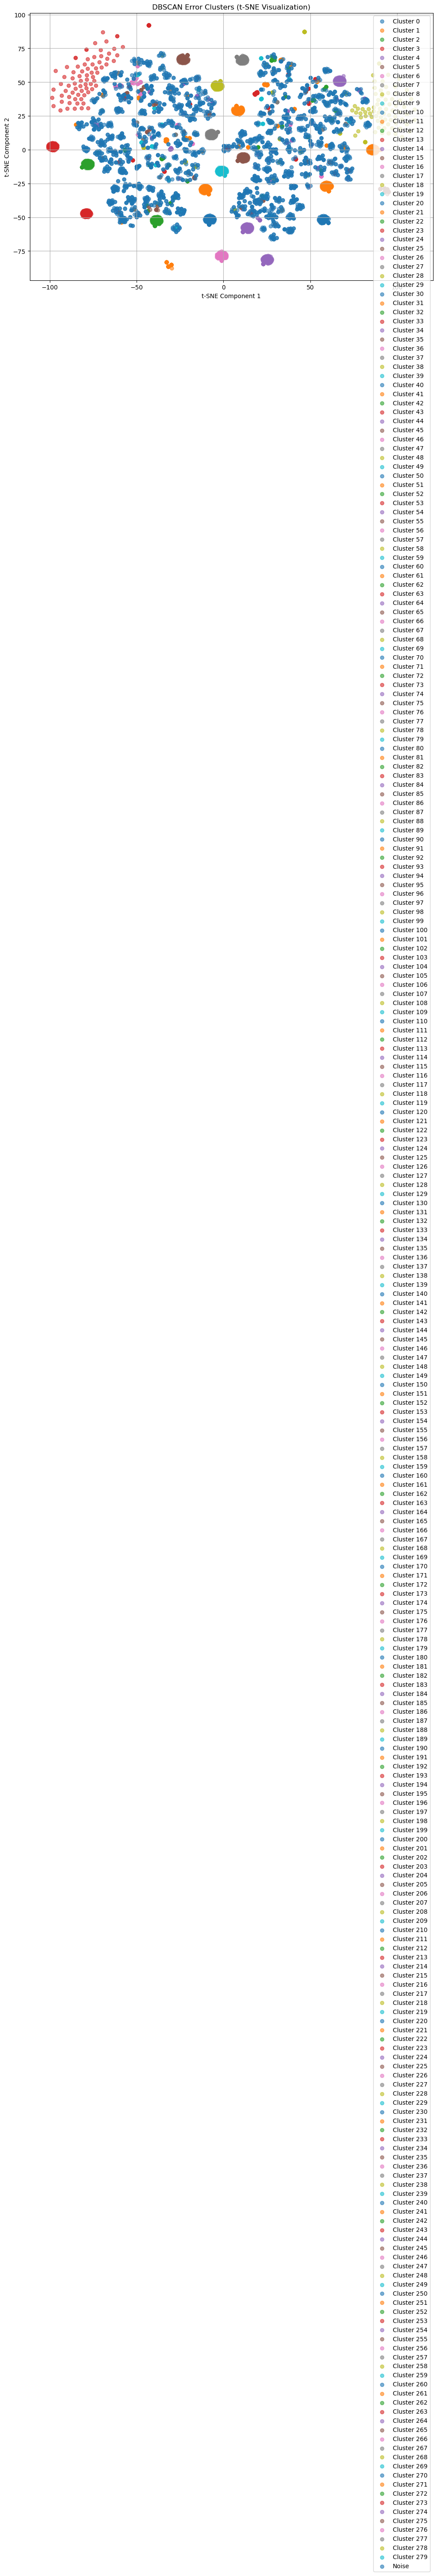

In [43]:
X_2d = apply_tsne(X)
plot_clusters_tsne(X_2d, labels)

In [44]:
def most_common_from_list_of_lists(series):
    all_items = [item for sublist in series if sublist for item in sublist]
    if all_items:
        return Counter(all_items).most_common(1)[0][0]
    return None

def summarize_feature_clusters(df, cluster_col='cluster'):
    grouped = df.groupby(cluster_col).agg({
        'path': lambda x: x.value_counts().index[0],
        'status': lambda x: x.value_counts().index[0],
        'ip': 'nunique',
        'params': most_common_from_list_of_lists,
        'timestamp': ['min', 'max', 'count']
    })

    # Rename multi-level columns
    grouped.columns = [
        'common_path', 'common_status', 'unique_ips',
        'common_param', 'start_time', 'end_time', 'log_count'
    ]
    grouped.reset_index(inplace=True)
    return grouped


In [45]:
cluster_summary = summarize_feature_clusters(features_df)
cluster_summary

,cluster,common_path,common_status,unique_ips,common_param,start_time,end_time,log_count
0,-1,wp-content/explore,404,2477,None,2025-01-01 01:51:10+05:30,2025-06-29 11:30:35+05:30,2477
1,0,list/tag,500,17,None,2025-01-01 01:17:30+05:30,2025-06-28 12:22:24+05:30,17
2,1,tag,404,109,None,2025-01-01 01:27:33+05:30,2025-06-25 01:46:27+05:30,109
3,2,list/tag,404,17,None,2025-01-01 01:43:17+05:30,2025-06-25 02:26:36+05:30,17
4,3,app,404,86,None,2025-01-01 01:44:25+05:30,2025-06-27 14:57:59+05:30,86
...,...,...,...,...,...,...,...,...
276,275,tags/wp-content/categories,500,7,None,2025-03-21 15:20:05+05:30,2025-06-23 01:20:29+05:30,7
277,276,main/search,500,5,None,2025-03-24 07:25:16+05:30,2025-06-25 21:40:33+05:30,5
278,277,tag/explore,404,5,None,2025-03-29 01:22:47+05:30,2025-06-05 10:26:32+05:30,5
279,278,categories/app,404,8,None,2025-03-29 03:15:55+05:30,2025-06-16 20:16:11+05:30,8


In [46]:
def compute_ip_request_counts(df, ip_column='ip'):
    ip_counter = Counter(df[ip_column])
    ip_freq_df = pd.DataFrame(ip_counter.items(), columns=['IP', 'Request Count'])
    ip_freq_df.sort_values(by='Request Count', ascending=False, inplace=True)
    return ip_freq_df

def plot_ip_request_distribution(ip_freq_df, bins=50):
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.histplot(ip_freq_df['Request Count'], bins=bins, kde=True, ax=ax)
    ax.set_title("Request Frequency Distribution per IP")
    ax.set_xlabel("Number of Requests")
    ax.set_ylabel("Number of IPs")
    ax.grid(True)
    fig.tight_layout()
    return fig


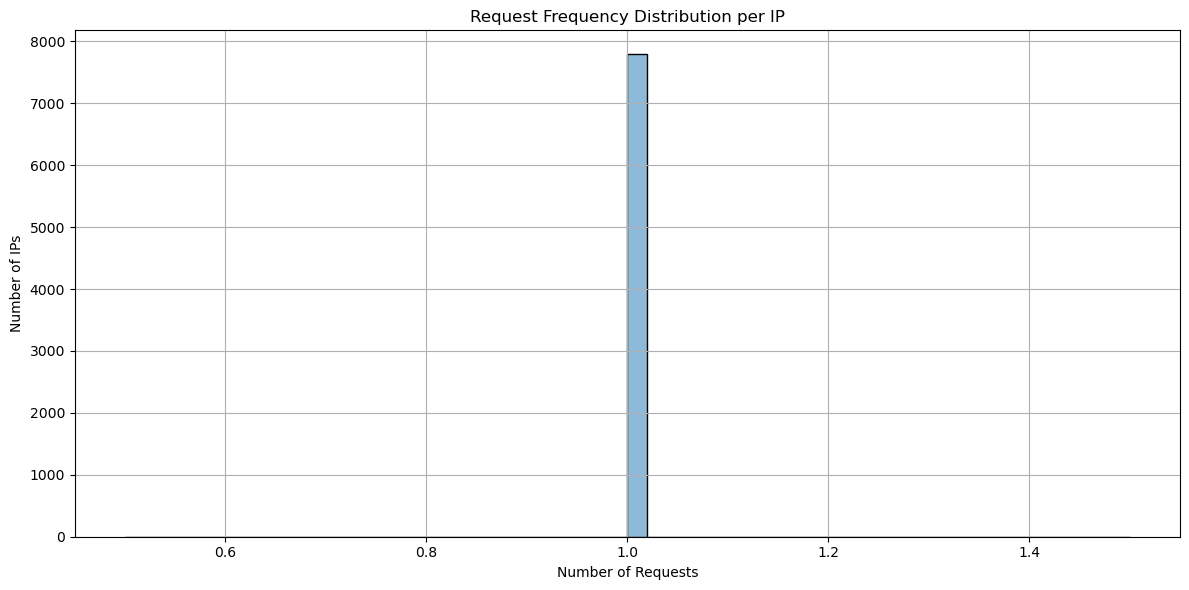

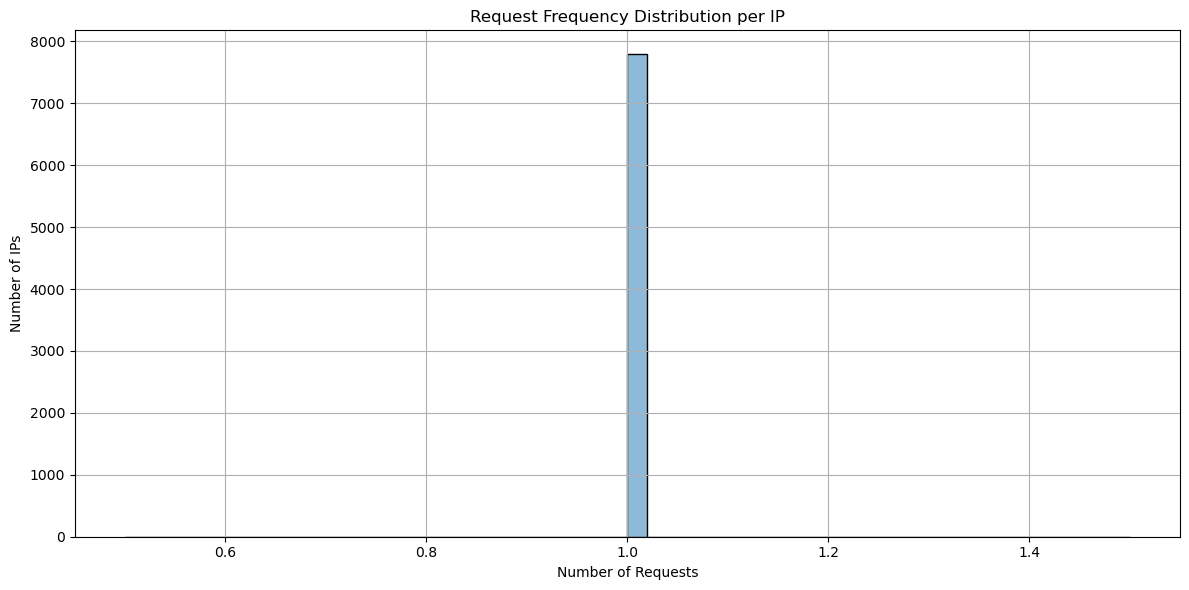

In [47]:
ip_freq_df = compute_ip_request_counts(error_logs_df)
plot_ip_request_distribution(ip_freq_df)

In [48]:
def detect_suspicious_ips(ip_freq_df, threshold_factor=3):
    mean = ip_freq_df['Request Count'].mean()
    std = ip_freq_df['Request Count'].std()
    threshold = mean + threshold_factor * std

    suspicious = ip_freq_df[ip_freq_df['Request Count'] > threshold]
    return suspicious, threshold


In [49]:
suspicious_ips, threshold = detect_suspicious_ips(ip_freq_df)
print("Suspicious High-Frequency IPs:")
print(suspicious_ips)

Suspicious High-Frequency IPs:
Empty DataFrame
Columns: [IP, Request Count]
Index: []


In [50]:
def extract_response_sizes(final_df, final_sessions, log_pattern):
    """
    Extracts response sizes from raw log lines and appends
    them as a new 'response_size' column to final_df.
    """
    response_sizes = []

    # Flatten sessions in the same order as final_df
    for session in final_sessions.values():
        for entry in session:
            match = log_pattern.match(entry[2])  # entry[2] = raw log line
            if match:
                size = match.group('size')
                if size.isdigit():
                    response_sizes.append(int(size))
                else:
                    response_sizes.append(0)  # Handle '-' or missing
            else:
                response_sizes.append(0)  # If pattern didn't match

    # Sanity check: match size with final_df length
    if len(response_sizes) != len(final_df):
        raise ValueError("Mismatch: response_sizes and final_df length differ.")

    # Add to final_df
    final_df = final_df.copy()
    final_df['response_size'] = response_sizes

    return final_df


def plot_response_size_distribution(response_sizes):
    size_df = pd.DataFrame({'Response Size': response_sizes})
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=size_df['Response Size'])
    plt.title("Response Size Distribution")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [51]:
response_df = extract_response_sizes(final_df,final_sessions, log_pattern)

In [52]:
import pandas as pd
from collections import Counter

def extract_response_sizes_from_sessions(final_sessions, log_pattern):
    response_sizes = []
    for session in final_sessions.values():
        for entry in session:
            match = log_pattern.match(entry[2])  # entry[2] = raw log line
            if match:
                size = match.group('size')
                if size.isdigit():  # Exclude "-" or invalid sizes
                    response_sizes.append(int(size))
    return response_sizes

def detect_response_size_outliers(size_series, iqr_multiplier=1.5):
    Q1 = size_series.quantile(0.25)
    Q3 = size_series.quantile(0.75)
    IQR = Q3 - Q1

    lower_threshold = Q1 - iqr_multiplier * IQR
    upper_threshold = Q3 + iqr_multiplier * IQR

    outliers = size_series[(size_series < lower_threshold) | (size_series > upper_threshold)]
    return outliers.to_frame(name='Response Size'), (lower_threshold, upper_threshold)

def process_response_size_outliers(final_sessions, log_pattern):
    response_sizes = extract_response_sizes_from_sessions(final_sessions, log_pattern)
    size_df = pd.DataFrame({'Response Size': response_sizes})
    size_outliers, thresholds = detect_response_size_outliers(size_df['Response Size'])
    return size_df, size_outliers, thresholds


In [53]:
size_df, size_outliers, (low_thresh, high_thresh) = process_response_size_outliers(final_sessions, log_pattern)
print("Response Size Outliers:")
print(size_outliers)

Response Size Outliers:
Empty DataFrame
Columns: [Response Size]
Index: []


In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def get_top_ips(ip_freq_df, top_n=20):
    return ip_freq_df.head(top_n)

def plot_top_ip_requests(top_ips_df, title="Top IPs by Request Volume"):
    fig, ax = plt.subplots(figsize=(14, 6))
    sns.barplot(data=top_ips_df, x='IP', y='Request Count', palette="viridis", ax=ax)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    fig.tight_layout()
    return fig


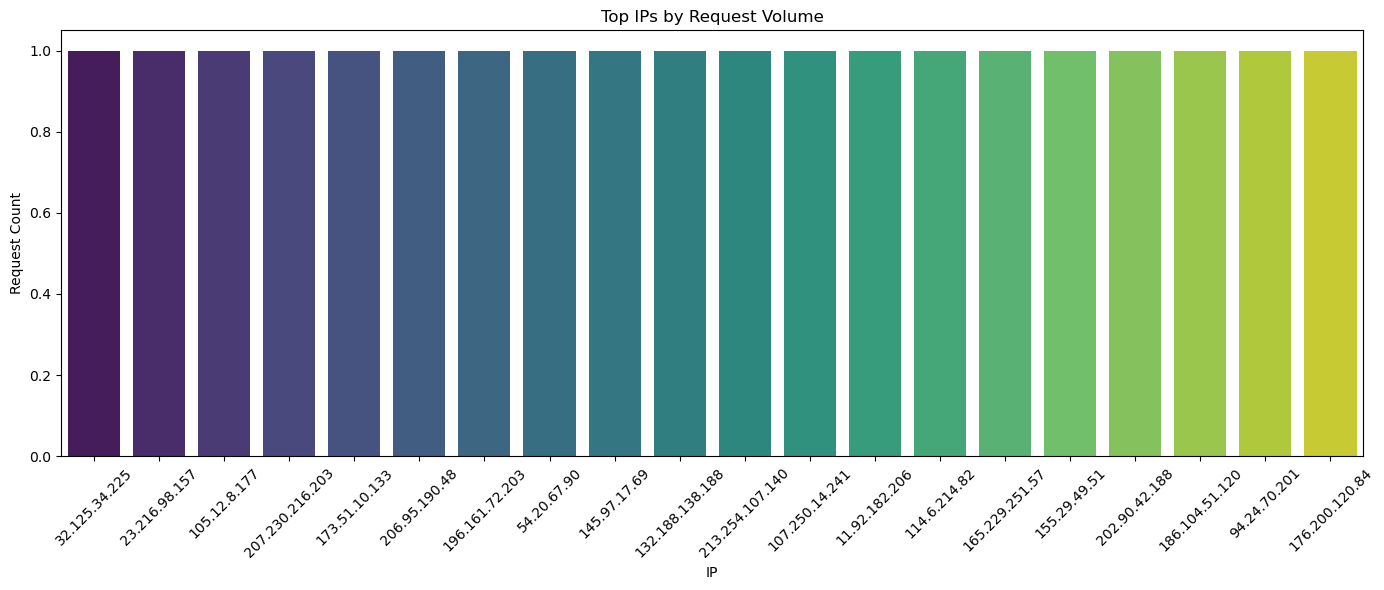

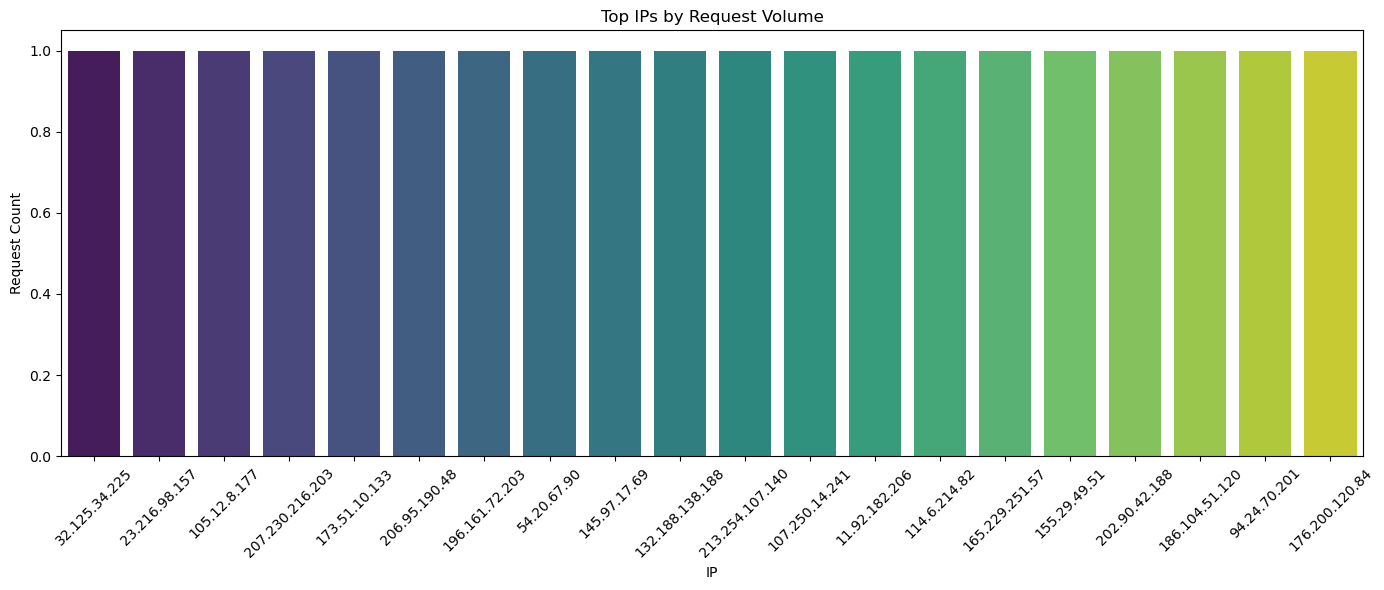

In [55]:
top_ips = get_top_ips(ip_freq_df, top_n=20)
plot_top_ip_requests(top_ips)

In [56]:
from collections import Counter
import pandas as pd

def analyze_user_agents(user_agent_series, suspicious_keywords=None):
    if suspicious_keywords is None:
        suspicious_keywords = ['curl', 'wget', 'bot', 'scanner', 'python-requests']

    user_agent_counter = Counter()
    suspicious_agents = []

    for agent in user_agent_series.dropna():
        agent_lower = agent.lower()
        user_agent_counter[agent_lower] += 1

        if any(keyword in agent_lower for keyword in suspicious_keywords):
            suspicious_agents.append(agent_lower)

    ua_df = pd.DataFrame(user_agent_counter.items(), columns=['User-Agent', 'Count'])
    ua_df.sort_values(by='Count', ascending=False, inplace=True)

    return ua_df, suspicious_agents


In [57]:
ua_df, suspicious_agents = analyze_user_agents(final_df['user_agent'])
print("Top User-Agents:")
ua_df

Top User-Agents:


,User-Agent,Count
0,curl/7.68.0,10055
1,wget/1.20.3 (linux-gnu),9710
2,mozilla/5.0 (x11; linux x86_64),124
3,mozilla/5.0 (windows nt 10.0; win64; x64),122
4,mozilla/5.0 (macintosh; intel mac os x 10_15_7),113


In [58]:
from urllib.parse import urlparse

def add_ip_frequency(session_df, ip_column='ip'):
    ip_freq_map = session_df[ip_column].value_counts().to_dict()
    session_df['ip_freq'] = session_df[ip_column].map(ip_freq_map)
    return session_df

def add_url_length(session_df, url_column='url'):
    session_df['url_length'] = session_df[url_column].apply(
        lambda u: len(urlparse(u).path) if isinstance(u, str) else 0
    )
    return session_df


In [59]:
session_df = add_ip_frequency(session_df)
session_df = add_url_length(session_df)

In [60]:
session_df

,ip,user_agent,timestamp,method,url,status,size,referrer,protocol,ip_freq,url_length
0,36.115.243.206,Mozilla/5.0 (X11; Linux x86_64),2025-01-27 23:39:35+05:30,POST,main/list/tags,301,3284,http://www.randall-day.com/index/,HTTP/1.1,1,14
1,124.50.101.62,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7),2025-03-23 09:34:19+05:30,HEAD,explore,301,3880,http://walsh.info/,HTTP/1.1,1,7
2,60.153.169.13,curl/7.68.0,2025-06-21 19:41:31+05:30,POST,main,500,1582,https://anderson-cuevas.org/home/,HTTP/1.1,1,4
3,126.237.5.191,Mozilla/5.0 (Windows NT 10.0; Win64; x64),2025-01-12 06:37:39+05:30,POST,list,302,4137,http://www.gomez.info/blog/explore/main/post.htm,HTTP/1.1,1,4
4,64.251.98.165,Mozilla/5.0 (Windows NT 10.0; Win64; x64),2025-05-21 04:34:29+05:30,HEAD,categories/tags/tag,404,2300,https://francis.info/post.php,HTTP/1.1,1,19
...,...,...,...,...,...,...,...,...,...,...,...
49995,87.191.50.159,Mozilla/5.0 (X11; Linux x86_64),2025-03-20 19:26:17+05:30,HEAD,blog/tag/tags,200,471,http://patterson.net/register/,HTTP/1.1,1,13
49996,63.176.144.9,curl/7.68.0,2025-03-25 10:10:39+05:30,GET,explore/tag,500,4126,https://www.rogers-johnson.com/category.jsp,HTTP/1.1,1,11
49997,62.197.255.115,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7),2025-01-17 06:51:39+05:30,GET,main/category/posts,301,4572,http://www.thompson.com/main/,HTTP/1.1,1,19
49998,16.165.92.181,Mozilla/5.0 (X11; Linux x86_64),2025-01-03 05:47:25+05:30,HEAD,tag/list,301,175,https://gordon-thompson.com/main.php,HTTP/1.1,1,8


In [61]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd

def encode_request_method(df, column='method'):
    le = LabelEncoder()
    df['method_encoded'] = le.fit_transform(df[column])
    return df, le

def add_hour_from_timestamp(df, timestamp_col='timestamp'):
    df['hour'] = df[timestamp_col].dt.hour
    return df

    df['referrer_length'] = df[referrer_col].apply(lambda x: len(x) if isinstance(x, str) else 0)
    return df

def prepare_isolation_forest_features(df, feature_cols):
    scaler = StandardScaler()
    X = df[feature_cols].copy()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, scaler

def add_referrer_length(df, referrer_col='referrer'):
    df['referrer_length'] = df[referrer_col].apply(lambda x: len(x) if isinstance(x, str) else 0)
    return df


In [62]:
session_df, le = encode_request_method(session_df)
session_df = add_hour_from_timestamp(session_df)
session_df = add_referrer_length(session_df)

feature_cols = [
    'ip_freq',
    'size',
    'url_length',
    'status',
    'method_encoded',
    'hour',
    'referrer_length'
]

X_scaled, scaler = prepare_isolation_forest_features(session_df, feature_cols)

In [63]:
X_scaled

array([[-0.0633788 ,  0.54318068,  0.26843317, ...,  1.25641258,
         1.67551989, -0.18981762],
       [-0.0633788 ,  0.96468705, -0.81111055, ...,  0.04227623,
        -0.35375826, -1.61330738],
       [-0.0633788 , -0.66051702, -1.27377214, ...,  1.25641258,
         1.09572613, -0.18981762],
       ...,
       [-0.0633788 ,  1.45408706,  1.03953583, ..., -1.17186012,
        -0.78860358, -0.56941489],
       [-0.0633788 , -1.65558323, -0.65689002, ...,  0.04227623,
        -0.93355202,  0.09488034],
       [-0.0633788 ,  0.49721103,  0.4226537 , ..., -1.17186012,
        -1.2234489 ,  1.5183701 ]])

In [64]:
from sklearn.metrics import calinski_harabasz_score

def calculate_calinski_score(model, X, feature_names=None):
    """
    Compute Calinski-Harabasz score for an Isolation Forest model.
    
    Parameters:
        model (IsolationForest): Trained model
        X (array-like): Feature matrix used for training
        feature_names (list, optional): List of feature column names
    
    Returns:
        float or str: Calinski-Harabasz score or message if not applicable
    """
    try:
        # Predict cluster labels
        labels = model.predict(X)
        
        # Remove outliers (-1)
        #inlier_mask = labels != -1
        #X_inliers = X[inlier_mask]
        #labels_inliers = labels[inlier_mask]

        if len(set(labels)) < 2:
            return "Not enough clusters for Calinski score"
        
        # Calculate Calinski-Harabasz score
        score = calinski_harabasz_score(X, labels)
        return score

    except Exception as e:
        return f"Error calculating score: {str(e)}"

In [65]:
from sklearn.metrics import silhouette_score

def calculate_silhouette_score(model, X):
    """
    Compute Silhouette Score for an Isolation Forest model (excluding outliers).
    
    Parameters:
        model (IsolationForest): Trained model
        X (array-like): Feature matrix used for training

    Returns:
        float or str: Silhouette Score or a message if not applicable
    """
    try:
        # Predict anomaly labels
        labels = model.predict(X)
        
        # Exclude outliers
        #inlier_mask = labels != -1
        #X_inliers = X[inlier_mask]
        #labels_inliers = labels[inlier_mask]

        # Must have at least 2 clusters
        if len(set(labels)) < 2:
            return "Not enough clusters for Silhouette score"

        score = silhouette_score(X, labels)
        return score

    except Exception as e:
        return f"Error calculating Silhouette Score: {str(e)}"


In [66]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import calinski_harabasz_score, silhouette_score
import joblib

def train_isolation_forest(X_scaled, contamination=0.02, random_state=42):
    model = IsolationForest(contamination=contamination, random_state=random_state)
    model.fit(X_scaled)
    joblib.dump(model, "isolation_forest_model.pkl")

def annotate_anomalies(df, model, X_scaled):
    df['anomaly_score'] = model.decision_function(X_scaled)
    df['is_anomaly'] = model.predict(X_scaled)  # -1 = anomaly, 1 = normal
    return df

def evaluate_isolation_forest(model, X, feature_names=None):
    cal_score = calculate_calinski_score(model, X, feature_names)
    sil_score = calculate_silhouette_score(model, X)
    return {"calinski_score": cal_score, "silhouette_score": sil_score}


In [68]:
# Train model
train_isolation_forest(X_scaled)
model = joblib.load("isolation_forest_model.pkl")

# Evaluate
scores = evaluate_isolation_forest(model, X_scaled, feature_cols)
print("Calinski Score:", scores['calinski_score'])
print("Silhouette Score:", scores['silhouette_score'])

# Annotate anomalies
session_df = annotate_anomalies(session_df, model, X_scaled)


Calinski Score: 1546.0682687084006
Silhouette Score: 0.4857605897200384


In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_anomaly_score_distribution(df, score_col='anomaly_score', label_col='is_anomaly'):
    sns.set(style="whitegrid", palette="muted")

    anomalies = df[df[label_col] == -1]

    plt.figure(figsize=(10, 6))
    sns.histplot(df[score_col], bins=50, kde=True, color='skyblue')
    if not anomalies.empty:
        plt.axvline(anomalies[score_col].max(), color='red', linestyle='--', label='Anomaly Threshold')
    plt.title('Distribution of Anomaly Scores')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()


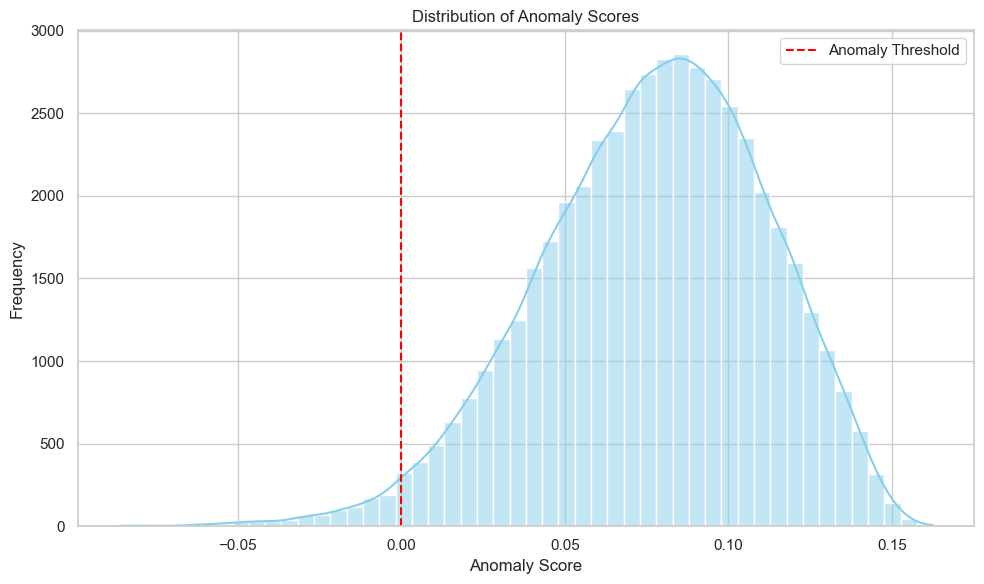

In [70]:
plot_anomaly_score_distribution(session_df)

In [71]:
def predict_anomaly(session_df, model, feature_cols, label_encoder=None, scaler=None):
    # Step 1: Add engineered features
    session_df = add_ip_frequency(session_df)
    session_df = add_url_length(session_df)
    session_df = add_hour_from_timestamp(session_df)
    session_df = add_referrer_length(session_df)

    # Step 2: Encode request method (reuse encoder if provided)
    if label_encoder:
        session_df['method_encoded'] = label_encoder.transform(session_df['method'])
    else:
        session_df, label_encoder = encode_request_method(session_df)

    # Step 3: Extract feature matrix
    X = session_df[feature_cols].copy()

    # Step 4: Scale features (reuse scaler if provided)
    if scaler:
        X_scaled = scaler.transform(X)
    else:
        X_scaled, scaler = prepare_isolation_forest_features(session_df, feature_cols)

    # Step 5: Predict anomalies
    session_df['anomaly_score'] = model.decision_function(X_scaled)
    session_df['is_anomaly'] = model.predict(X_scaled)  # -1 = anomaly, 1 = normal

    return session_df

In [72]:
def create_timelines(df, timestamp_col='timestamp', label_col='is_anomaly', status_col='status'):
    # Round timestamps to nearest hour
    df['time_bin'] = df[timestamp_col].dt.floor('H')

    # Build timelines
    anomaly_timeline = df[df[label_col] == -1].groupby('time_bin').size()
    error_timeline = df[df[status_col] >= 400].groupby('time_bin').size()
    total_timeline = df.groupby('time_bin').size()

    return {
        'anomaly': anomaly_timeline,
        'error': error_timeline,
        'total': total_timeline
    }


In [73]:
timelines = create_timelines(session_df)
anomaly_timeline = timelines['anomaly']
error_timeline = timelines['error']
total_timeline = timelines['total']

timeline_df = pd.DataFrame({
    'total_events': total_timeline,
    'anomalies': anomaly_timeline,
    'errors': error_timeline
}).fillna(0)  # Fill missing bins with 0


In [74]:
import matplotlib.pyplot as plt

def plot_event_timelines(timeline_df, time_col=None):
    fig, ax = plt.subplots(figsize=(14, 6))

    x = timeline_df[time_col] if time_col else timeline_df.index

    ax.plot(x, timeline_df['total_events'], label='Total Requests', alpha=0.3, linestyle='--')
    ax.plot(x, timeline_df['errors'], label='Errors (4xx/5xx)', color='orange', linewidth=2)
    ax.plot(x, timeline_df['anomalies'], label='Anomalies (IF)', color='red', linewidth=2)

    ax.set_title('Timeline of Anomalies and Error Spikes')
    ax.set_xlabel('Time')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
    ax.grid(True)
    fig.tight_layout()

    return fig



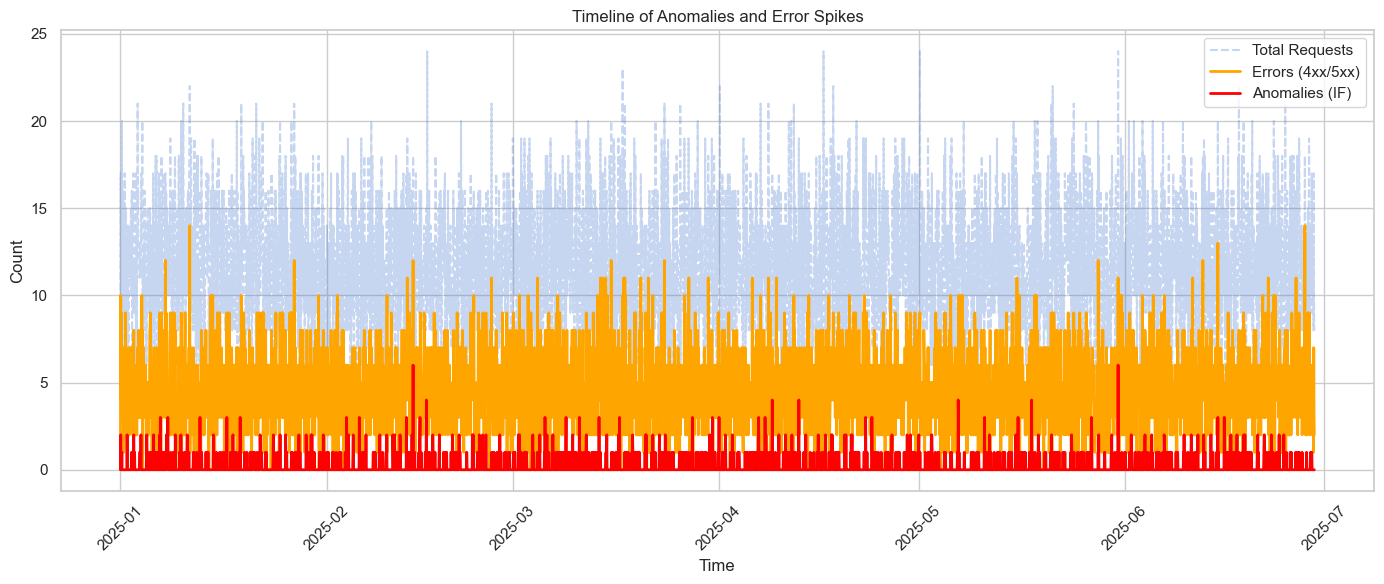

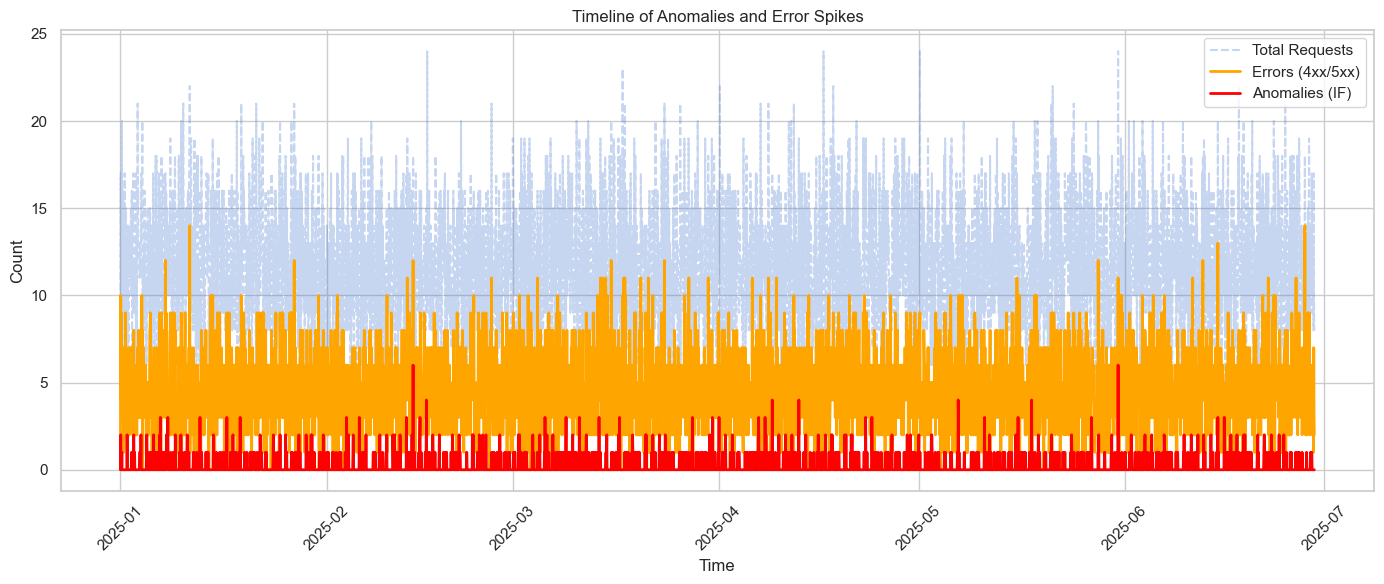

In [75]:
plot_event_timelines(timeline_df)

In [76]:
# Define all zero-day indicators
zero_day_indicators = [
    # Directory Traversal
    r'\.\./', r'/etc/passwd', r'\\x[0-9a-fA-F]{2}',

    # SQL Injection (SQLi)
    r'select\s+.+\s+from', r'union\s+select', r'--', r';--', r"' or 1=1", r'" or 1=1',
    r'waitfor delay', r'sleep\(', r'benchmark\(',

    # Cross-site Scripting (XSS)
    r'<script>', r'javascript:', r'onerror=', r'onload=', r'alert\(', r'document\.cookie',

    # Brute Force Login
    r'(login|signin|auth)[^a-zA-Z]?', r'password=[^&]{0,10}', r'admin.*password', r'user=.*&pass=.*',

    # Denial of Service (DoS)
    r'(ping|flood|slowloris|%00)+', r'(\bnull\b|\bundefined\b){10,}', r'\b(?:sleep|waitfor|delay)\b',

    # User-Agent Spoofing
    r'curl/', r'wget/', r'nmap/', r'nikto', r'python-requests', r'\bjava\b', r'\bruby\b',

    # Suspicious Downloads
    r'\.exe\b', r'\.bat\b', r'\.sh\b', r'\.jar\b', r'\.py\b', r'\.ps1\b', r'/download/',

    # File Upload/Execution
    r'\.php\b', r'\.asp\b', r'\.jsp\b', r'upload', r'multipart/form-data', r'content-disposition', r'filename=',

    # Command Injection
    r'cmd=', r'eval\(', r'exec\(', r'base64_decode\(',
]

# Compile into regex
zero_day_pattern = re.compile(r'(' + '|'.join(zero_day_indicators) + r')', re.IGNORECASE)


def contains_zero_day_signature(url):
    return bool(zero_day_pattern.search(url)) if isinstance(url, str) else False


def detect_zero_day_anomalies(df, url_col='url', anomaly_col='is_anomaly'):
    df['zero_day_suspect'] = df[url_col].apply(contains_zero_day_signature)

    correlated_df = df[
        (df[anomaly_col] == -1) &
        (df['zero_day_suspect'] == True)
    ]

    return df, correlated_df


In [77]:
session_df, correlated_zero_days = detect_zero_day_anomalies(session_df)

print(f"Correlated zero-day anomalies: {len(correlated_zero_days)}")

print("Top source IPs of suspected zero-day anomalies:")
print(correlated_zero_days['ip'].value_counts().head(10))


Correlated zero-day anomalies: 5
Top source IPs of suspected zero-day anomalies:
ip
90.47.2.159       1
15.33.171.61      1
185.212.205.49    1
181.96.181.223    1
161.100.38.100    1
Name: count, dtype: int64


In [78]:
import re
from collections import defaultdict

def build_multi_phase_timeline(df, timestamp_col='timestamp'):
    return df.groupby(df[timestamp_col].dt.floor('H')).size()


def detect_multi_phase_behavior(df, url_col='url', ip_col='ip', size_col='size', size_threshold=50000):
    phases = defaultdict(lambda: {
        'entry': 0, 'exfil': 0, 'delete': 0,
        'entry_urls': [], 'exfil_urls': [], 'delete_urls': []
    })

    for _, row in df.iterrows():
        ip = row[ip_col]
        url = (row[url_col] or '').lower()
        size = row.get(size_col, 0)

        # Entry Phase
        if re.search(r'\b(login|admin|index|signin|auth)\b', url):
            phases[ip]['entry'] += 1
            phases[ip]['entry_urls'].append(url)

        # Exfiltration Phase
        if re.search(r'\b(download|\.zip|\.sql|export|dump)\b', url) or size > size_threshold:
            phases[ip]['exfil'] += 1
            phases[ip]['exfil_urls'].append(url)

        # Deletion Phase
        if re.search(r'\b(delete|drop|remove|wipe|truncate)\b', url):
            phases[ip]['delete'] += 1
            phases[ip]['delete_urls'].append(url)

    # Filter IPs with all three phases
    multi_phase_ips = {
        ip: details for ip, details in phases.items()
        if details['entry'] > 0 and details['exfil'] > 0 and details['delete'] > 0
    }

    return multi_phase_ips


In [79]:
# Step 1: Build timeline of correlated zero-day anomalies
timeline = build_multi_phase_timeline(correlated_zero_days)

# Step 2: Detect multi-phase behavior
multi_phase_ips = detect_multi_phase_behavior(correlated_zero_days)

# Step 3: View
print("Multi-phase behavior IPs detected:")
multi_phase_ips

Multi-phase behavior IPs detected:


{}

In [80]:
def build_hourly_timeline(df, timestamp_col, filter_condition=None, value_name='count'):
    if filter_condition is not None:
        df = df.loc[filter_condition(df)].copy()
    else:
        df = df.copy()

    df['hour'] = df[timestamp_col].dt.floor('H')
    return df.groupby('hour').size().reset_index(name=value_name)


In [81]:
# Anomaly timeline
anomaly_timeline = build_hourly_timeline(
    session_df, 
    timestamp_col='timestamp',
    filter_condition=lambda df: df['is_anomaly'] == -1,
    value_name='anomaly_count'
)

# Error timeline (status >= 400)
error_timeline = build_hourly_timeline(
    session_df, 
    timestamp_col='timestamp',
    filter_condition=lambda df: df['status'] >= 400,
    value_name='error_count'
)

# Correlated zero-day anomaly timeline
correlated_timeline = build_hourly_timeline(
    correlated_zero_days,
    timestamp_col='timestamp',
    value_name='correlated_count'
)


In [82]:
def merge_timelines(timelines, on='hour', how='outer'):
    from functools import reduce

    # Merge using reduce for multiple dataframes
    merged = reduce(lambda left, right: pd.merge(left, right, on=on, how=how), timelines)

    # Sort and fill missing counts with 0
    merged = merged.sort_values(on).fillna(0)

    return merged


In [83]:
timeline = merge_timelines([anomaly_timeline, error_timeline, correlated_timeline])


In [84]:
def plot_forensic_timeline(timeline_df):
    plt.figure(figsize=(14, 6))

    plt.plot(timeline_df['hour'], timeline_df['anomaly_count'], label='Anomalies', color='red', linewidth=2)
    plt.plot(timeline_df['hour'], timeline_df['error_count'], label='Errors (4xx/5xx)', color='blue', linewidth=2)
    plt.plot(timeline_df['hour'], timeline_df['correlated_count'], label='Zero-Day Correlated', color='green', linewidth=2)

    plt.xlabel("Time (Hourly)")
    plt.ylabel("Event Count")
    plt.title("Forensic Timeline: Anomalies, Errors, Zero-Day Indicators")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


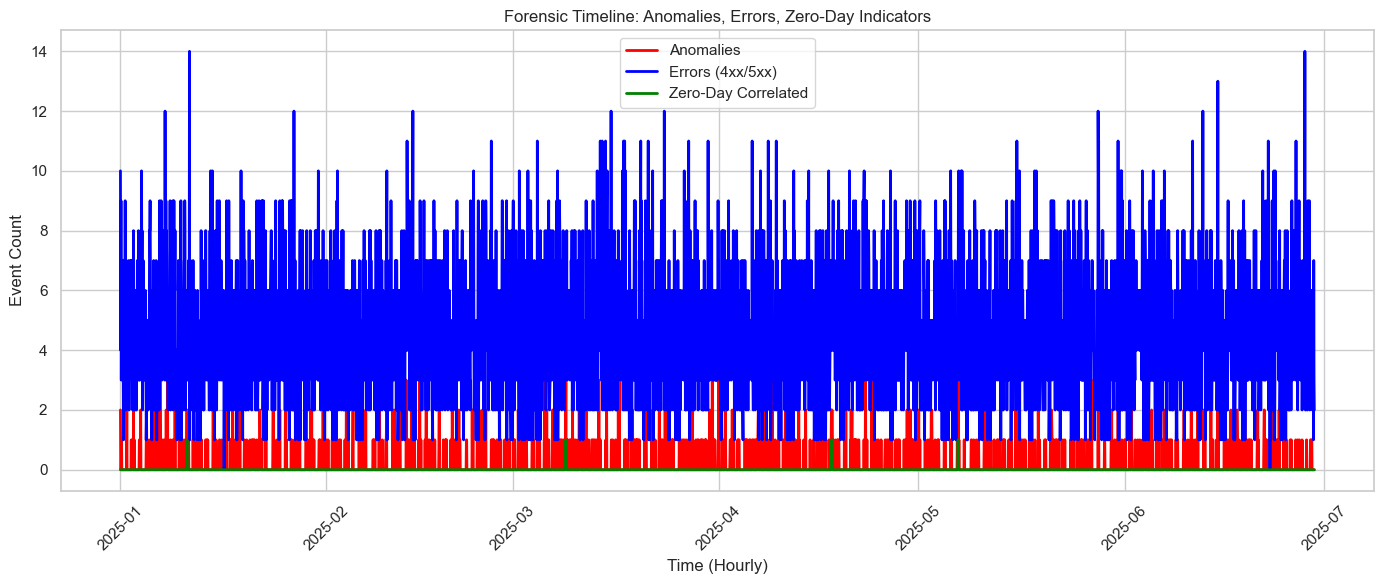

In [85]:
plot_forensic_timeline(timeline)

In [86]:
def get_suspicious_ips(df, multi_phase_ips_dict):

    anomalous_ips = set(df[df['is_anomaly'] == -1]['ip'])
    multi_phase_ip_set = set(multi_phase_ips_dict.keys())

    suspicious_ips = anomalous_ips | multi_phase_ip_set

    print(f"Total suspicious IPs: {len(suspicious_ips)}")
    print(f"Suspicious IPs: {list(suspicious_ips)}")

    return suspicious_ips


In [87]:
suspicious_ips = get_suspicious_ips(correlated_zero_days, multi_phase_ips)

Total suspicious IPs: 5
Suspicious IPs: ['15.33.171.61', '181.96.181.223', '90.47.2.159', '161.100.38.100', '185.212.205.49']


In [88]:
import subprocess
import re

def extract_whois_info(ip, verbose=True):

    info = {
        "ip": ip,
        "organization": None,
        "country": None,
        "nameservers": [],
        "location": None
    }

    try:
        result = subprocess.run(['whois', ip], capture_output=True, text=True, timeout=10)
        whois_text = result.stdout

        # Extract fields using regex
        org = re.search(r'Registrant Organization:\s*(.+)', whois_text, re.IGNORECASE)
        country = re.search(r'Registrant Country:\s*(.+)', whois_text, re.IGNORECASE)
        nameservers = re.findall(r'Name Server:\s*(.+)', whois_text, re.IGNORECASE)
        location = re.search(r'Location:\s*(.+)', whois_text, re.IGNORECASE)

        # Update dictionary
        info["organization"] = org.group(1).strip() if org else "Not Found"
        info["country"] = country.group(1).strip() if country else "Not Found"
        info["nameservers"] = nameservers if nameservers else ["Not Found"]
        info["location"] = location.group(1).strip() if location else "Not Found"

        # Verbose output
        if verbose:
            print(f"{'='*50}")
            print(f"WHOIS Lookup for IP: {ip}")
            print(f"{'-'*50}")
            print(f"Registrant Organization: {info['organization']}")
            print(f"Registrant Country    : {info['country']}")
            print(f"Name Servers          : {', '.join(info['nameservers'])}")
            print(f"Location              : {info['location']}")
            print(f"{'='*50}")

    except Exception as e:
        info["error"] = str(e)
        if verbose:
            print(f"Error during WHOIS lookup for {ip}: {e}")

    return info


In [89]:
whois_results = [extract_whois_info(ip, verbose=True) for ip in suspicious_ips]

WHOIS Lookup for IP: 15.33.171.61
--------------------------------------------------
Registrant Organization: Not Found
Registrant Country    : Not Found
Name Servers          : Not Found
Location              : Not Found
WHOIS Lookup for IP: 181.96.181.223
--------------------------------------------------
Registrant Organization: Not Found
Registrant Country    : Not Found
Name Servers          : Not Found
Location              : Not Found
WHOIS Lookup for IP: 90.47.2.159
--------------------------------------------------
Registrant Organization: Orange Brand Services Limited
Registrant Country    : GB
Name Servers          : NS1.ORANGE.FR, NS2.ORANGE.FR, ns2.orange.fr, ns1.orange.fr, ns2.orange.fr, ns1.orange.fr
Location              : Not Found
WHOIS Lookup for IP: 161.100.38.100
--------------------------------------------------
Registrant Organization: Not Found
Registrant Country    : Not Found
Name Servers          : Not Found
Location              : Not Found
WHOIS Lookup for 

In [111]:
def get_geolocation(ip):
    token = 'bd8e0e57447180'
    url = f"https://ipinfo.io/{ip}/json?token={token}"
    
    try:
        response = requests.get(url, timeout=5)

        if response.status_code == 429:
            time.sleep(2)
            response = requests.get(url, timeout=5)

        if response.status_code == 200:
            data = response.json()
            loc = data.get("loc", "")
            if loc:
                lat, lon = map(float, loc.split(","))
                return lat, lon, data.get("city", ""), data.get("country", "")
    except Exception:
        pass

    return None, None, "", ""

# ------------------------------------------

def geolocation(suspicious_ips, session_df, multi_phase_ips=None, max_ips=20):
    if multi_phase_ips is None:
        multi_phase_ips = set()

    geo_data = []
    seen_ips = set()

    # Limit IPs for faster geolocation
    rule_based_limited = list(suspicious_ips)[:max_ips]

    # 1. Rule-based IPs
    for ip in rule_based_limited:
        if ip not in seen_ips:
            lat, lon, city, country = get_geolocation(ip)
            is_multi = 1 if ip in multi_phase_ips else 0
            geo_data.append({
                "ip": ip, "lat": lat, "lon": lon, "city": city,
                "country": country, "is_multi_phase": is_multi
            })
            seen_ips.add(ip)

    # 2. Isolation Forest Anomaly IPs
    if 'ip' in session_df.columns and 'is_anomaly' in session_df.columns:
        anomaly_ips = session_df[session_df['is_anomaly'] == -1]['ip'].unique()
        anomaly_limited = [ip for ip in anomaly_ips if ip not in seen_ips][:max_ips]

        for ip in anomaly_limited:
            lat, lon, city, country = get_geolocation(ip)
            is_multi = 1 if ip in multi_phase_ips else 0
            geo_data.append({
                "ip": ip, "lat": lat, "lon": lon, "city": city,
                "country": country, "is_multi_phase": is_multi
            })
            seen_ips.add(ip)

    # Build DataFrame
    geo_df = pd.DataFrame(geo_data)
    if {'lat', 'lon'}.issubset(geo_df.columns):
        geo_df.dropna(subset=['lat', 'lon'], inplace=True)
    else:
        geo_df = pd.DataFrame(columns=["ip", "lat", "lon", "city", "country", "is_multi_phase"])

    return geo_df

In [112]:
geo_df=geolocation(suspicious_ips,session_df,multi_phase_ips)


In [113]:
region_summary = geo_df.groupby('country').size().reset_index(name='count')
region_summary = region_summary.sort_values(by='count', ascending=False)
print(region_summary)


   country  count
11      US      9
4       FR      2
7       JP      2
10      NL      2
0       AR      1
1       CN      1
2       DE      1
3       ES      1
5       GB      1
6       IT      1
8       KR      1
9       MY      1
12      ZM      1


In [114]:
import os
import re
import hashlib
import pandas as pd

# Step 1: Hash computation function
def compute_hashes(filepath):
    if not os.path.isfile(filepath):
        return None, None
    
    sha256 = hashlib.sha256()
    md5 = hashlib.md5()
    try:
        with open(filepath, 'rb') as f:
            while chunk := f.read(8192):
                sha256.update(chunk)
                md5.update(chunk)
        return sha256.hexdigest(), md5.hexdigest()
    except FileNotFoundError:
        return None, None

# Step 2: Detect suspicious downloads
def detect_suspicious_downloads(df, exfil_pattern, size_threshold=50000):
    required_cols = ['url', 'size']
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"Missing columns: {set(required_cols) - set(df.columns)}")

    suspicious = df[
        df['url'].str.contains(exfil_pattern, case=False, na=False) &
        (df['size'] > size_threshold)
    ].copy()
    
    suspicious['filename'] = suspicious['url'].apply(
        lambda x: os.path.basename(x.split('?')[0]) if isinstance(x, str) else None
    )
    return suspicious

# Step 3: Compare file hashes
def compare_file_integrity(filenames, suspected_dir='suspected/', original_dir='originals/'):
    report = []
    filename = os.path.basename(filename)

    for filename in filenames:
        suspected_path = os.path.join(suspected_dir, filename)
        original_path = os.path.join(original_dir, filename)

        sus_sha, sus_md5 = compute_hashes(suspected_path)
        ori_sha, ori_md5 = compute_hashes(original_path)

        if sus_sha is None or ori_sha is None:
            status = 'Missing'
        elif sus_sha != ori_sha or sus_md5 != ori_md5:
            status = 'Tampered'
        else:
            status = 'OK'

        report.append({
            'file': filename,
            'sha256_suspected': sus_sha,
            'sha256_original': ori_sha,
            'md5_suspected': sus_md5,
            'md5_original': ori_md5,
            'integrity': status
        })
    
    return pd.DataFrame(report)

# Step 4: Run full workflow
def run_file_integrity_check(final_df, exfil_regex=r'\.zip$|\.pdf$|\.sql$|\.csv$|\.xlsx$|\.db$|\.bak$|download|export',
                             suspected_dir='suspected/', original_dir='originals/'):
    
    suspicious_downloads = detect_suspicious_downloads(final_df, exfil_regex)
    unique_files = suspicious_downloads['filename'].dropna().unique()

    if not len(unique_files):
        return pd.DataFrame(columns=["file", "sha256_suspected", "sha256_original", "md5_suspected", "md5_original", "integrity"])
    
    integrity_df = compare_file_integrity(unique_files, suspected_dir, original_dir)
    return integrity_df


In [115]:
integrity_df = run_file_integrity_check(final_df)
print("File Integrity Report:")
print(integrity_df)

File Integrity Report:
Empty DataFrame
Columns: [file, sha256_suspected, sha256_original, md5_suspected, md5_original, integrity]
Index: []


In [116]:
integrity_df

,file,sha256_suspected,sha256_original,md5_suspected,md5_original,integrity


In [117]:
import re

def detect_exfiltration_logs(df, size_threshold=50000, exfil_pattern=None):

    if exfil_pattern is None:
        exfil_pattern = r'\.zip$|\.sql$|\.csv$|\.db$|download|export|backup'

    # Filter suspicious logs
    suspicious_logs = df[
        df['url'].str.contains(exfil_pattern, case=False, na=False) &
        (df['size'] > size_threshold)
    ].copy()

    # Select relevant columns
    suspicious_logs = suspicious_logs[['timestamp', 'ip', 'url', 'size']]
    
    return suspicious_logs


In [118]:
exfil_logs = detect_exfiltration_logs(final_df)
exfil_logs

,timestamp,ip,url,size


In [119]:
def get_exfiltration_logs(df, exfil_pattern=None, size_threshold=50000):
    if exfil_pattern is None:
        exfil_pattern = r'\.zip$|\.sql$|\.csv$|\.db$|download|export|backup'

    filtered_logs = df[
        df['url'].str.contains(exfil_pattern, case=False, na=False) &
        (df['size'] > size_threshold)
    ].copy()

    return filtered_logs[['timestamp', 'ip', 'url', 'size']]


In [120]:
exfil_logs = get_exfiltration_logs(final_df)
exfil_logs

,timestamp,ip,url,size


In [121]:
def flag_suspicious_exfil_logs(exfil_logs_df, suspicious_ips):
    exfil_logs_df = exfil_logs_df.copy()
    exfil_logs_df['is_suspicious_ip'] = exfil_logs_df['ip'].isin(suspicious_ips).astype(int)
    return exfil_logs_df


In [122]:
exfil_logs_flagged = flag_suspicious_exfil_logs(exfil_logs, suspicious_ips)
print(exfil_logs_flagged.sort_values(by='timestamp'))

Empty DataFrame
Columns: [timestamp, ip, url, size, is_suspicious_ip]
Index: []
